# Setup
1. install the Azure eventhub Python package
2. May need to re-start the runtime.

In [ ]:
%pip install azure-eventhub

# Intro to Azure EventHub
Azure Event Hubs is a big data streaming platform and event ingestion service. It can receive and process millions of events per second. Data sent to an event hub can be transformed and stored by using any real-time analytics provider or batching/storage adapters.

Scalability is achieved via a parallel architecture.

## EventHub Architecture
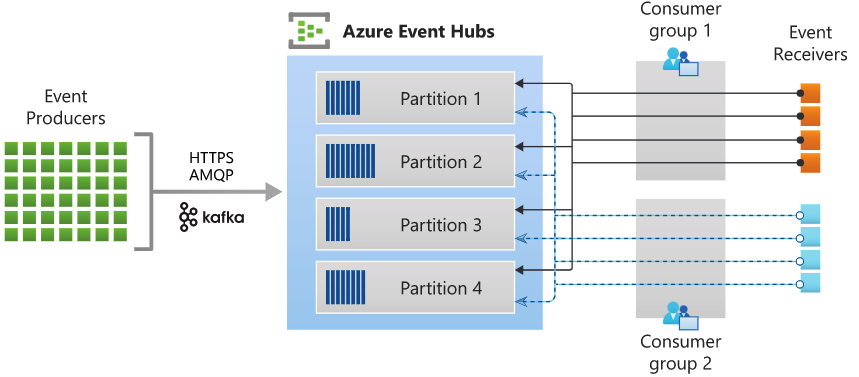





See: https://docs.microsoft.com/en-us/azure/event-hubs/event-hubs-about


# The EventHub Consumer
EventHub consumers (event receiver in the diagram above) can be used to drive dashbaord applications.  In our simple usecase, we will receive the raw messages routed from Azure IoT Hub to the EventHub.

In our Dev Day session, we will also demonstrate a simple Plotly/Dash application that plots the raw data and receives Alerts generated by SAS Intelligent Monitoring.

### Authentication
Similar to the IoT Hub Device simulator, our consumer uses Shared Access Signature authentication to connect to the EventHub.

In [2]:
from azure.eventhub import EventHubConsumerClient
from multiprocessing import Queue
from datetime import datetime
import logging

In [3]:
CONSUMER_GROUP = '$default'
D2C_EVENTHUB_NAME = 'imreceiverinput' #has 2 partitions
logger = logging.getLogger("azure.eventhub")
logging.basicConfig(level=logging.WARN)

# In a live environment, this should be loaded from an environment variable, not in code
CONN_STR='Endpoint=sb://simrioteventhubns.servicebus.windows.net/;SharedAccessKeyName=RootManageSharedAccessKey;SharedAccessKey=Gl0MbGOeYzhkYo7+/aLTNrl1/hSJSro/U+Z4VmdctTU='


In [4]:
# Utilities
def UTC_now_string():
    return( datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f") )

# Consumer class
A simple class to consume Azure Event Hub data. You will notice he consumer is initialized with a Queue object.  We don't use it here, but in the context of an application (such as the dashboard demo),the Queue is used to pass data from the consumer to the processing functions of the app.

In [5]:

class EventConsumer:
    _client=None
    _conn_string=None
    _consumer_group=None
    _eventhub_name=None
    _queue=None
    _recv_task=None
        
    def __init__(self, connection_string, consumer_group, eventhub_name, queue):
        self._conn_string=connection_string
        self._consumer_group=consumer_group
        self._eventhub_name=eventhub_name
        self._queue=queue
    
    
    def on_event(self,partition_context, event):
        logger.info("Received event from partition {a} at {b}".format(a=partition_context.partition_id, b=UTC_now_string()) )
        print(event.body_as_str())
        partition_context.update_checkpoint(event)
        try:
            self._queue.put( event.body_as_str() )
        except:
            logger.error('An error occurred')

    def on_error(self, partition_context, exception):
        logger.error(exception)
    
    def create(self):
        self._client = EventHubConsumerClient.from_connection_string(
                self._conn_string, 
                self._consumer_group, 
                eventhub_name=self._eventhub_name,
                retry_total=2,
                logging_enable=True,
                on_error=self.on_error)
    
    def start(self):
        with self._client:
            self._client.receive(on_event=self.on_event, 
                                 starting_position=-1)
    

In [6]:
d2c_q = Queue()
d2c_consumer=EventConsumer(CONN_STR, CONSUMER_GROUP, D2C_EVENTHUB_NAME, d2c_q)
d2c_consumer.create()

## Start the Consumer
Click the stop button on the cell to shut down

In [ ]:
d2c_consumer.start()

## Function Version


In [ ]:
# Event Hub D2C CONSUMER
###########################################################
def d2c_consumer(q):
    def on_event(partition_context, event):
        logger.info("D2C Received event from partition {a} at {b}".format(a=partition_context.partition_id, b=UTC_now_string()) )
        #logger.info(event.body_as_str())
        print( event.body_as_str() )
        partition_context.update_checkpoint(event)
        try:
            q.put( event.body_as_str() )
        except:
            pass

    client = EventHubConsumerClient.from_connection_string(
                CONN_STR, CONSUMER_GROUP, 
                eventhub_name=D2C_EVENTHUB_NAME, logging_enable=True)
    with client:
        client.receive(
            on_event=on_event,
            starting_position="-1",  # "-1" is from the beginning of the partition.
        )


In [ ]:
# Run the consumer

## Q for receiving new DEVICE DATA
d2c_q = Queue()
d2c_consumer(d2c_q,)
